# Project: Nonlinear Elliptic Problem POD vs PINNs

Let us consider the two-dimensional spatial domain $\Omega = [0, 1]^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0,\mu_1) \in P = [0.1,1]^2$, find $u(\mu)$ such that

$-\Delta u(\mu)+\frac{\mu_0}{\mu_1}(e^{\mu_1 u(\mu)}-1) = g(x;\mu)$,

with homogeneous Dirichlet boundary conditions and the source term defined as 

$g(x;\mu) = 100\sin(2\pi x_0)\cos(2\pi x_1) \ \ \ \forall x = (x_0,x_1) \in \Omega$.

In particular, we will solve the problem by means of POD-Galerkin method over a finite element full order model and then with a parametric PINN. We want to compare the two approaches in terms of computational costs and accuracy with respect to the full order model.

### Import libraries

In [1]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt

### Initialize

In [2]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [3]:

def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Progetto_b(numPoints, points):
	values_b = mu[0]/mu[1]*np.ones(numPoints, order='F')
	return values_b.ctypes.data

'''def Progetto_b(numPoints, points):
	values_b = (mu_0/mu_1)*np.ones((2, numPoints), order='F')
	return values_b.ctypes.data

def Progetto_c(numPoints, points):
	values_c = np.ones(numPoints, order='F')
	return values_c.ctypes.data

def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = vecu
	return values_nl_b.ctypes.data'''

def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu[0]*np.exp(mu[1]*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu[0]/mu[1]*(np.exp(mu[1]*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data


def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = np.zeros(numPoints)
    for i in range(numPoints):
        values_g[i] = 100*mt.sin(2*mt.pi*matPoints[0,i])*mt.cos(2*mt.pi*matPoints[1,i])
    return values_g.ctypes.data


def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu[0]/mu[1]*(np.exp(mu[1]*vecu)-1)
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

### Definition of Simulation Parameters

Geometry parameters

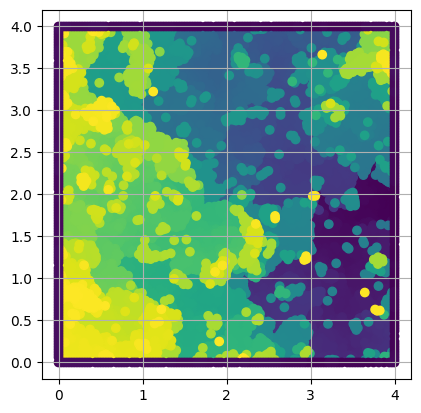

(3, 12214)


In [4]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 4.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotDofs(mesh,dofs,strongs)
print(dofs.shape)

Newton parameters

In [5]:
residual_norm = 1.0
solution_norm = 1.0
newton_tol = 1.0e-6
max_iterations = 10
num_iteration = 1

### Newton Algorithm

In [6]:
mu = [0.001, 10]

u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
print("HIGH FIDELITY SOLUTION")
while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k, u_strong, problemData, lib)

    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
    
    du = gedim.LUSolver(stiffness + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k = u_k + du

    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    
    num_iteration = num_iteration + 1

HIGH FIDELITY SOLUTION
dofs h iteration max_iteration
12214 6.9877124296868431e-02 1 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 2 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 3 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 4 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 5 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 6 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 7 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 8 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 9 10


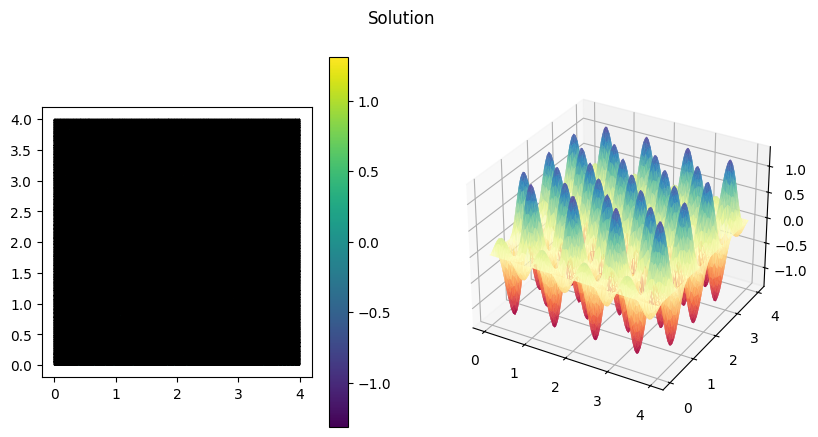

In [7]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [8]:
mu = [1, 1]

num_iteration = 1
u_k1 = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
print("HIGH FIDELITY SOLUTION")
while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k1, u_strong, problemData, lib)

    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k1, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k1, u_strong, problemData, lib)
    
    du = gedim.LUSolver(stiffness + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k1 = u_k1 + du

    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    
    num_iteration = num_iteration + 1

HIGH FIDELITY SOLUTION
dofs h iteration max_iteration
12214 6.9877124296868431e-02 1 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 2 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 3 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 4 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 5 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 6 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 7 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 8 10
dofs h iteration max_iteration
12214 6.9877124296868431e-02 9 10


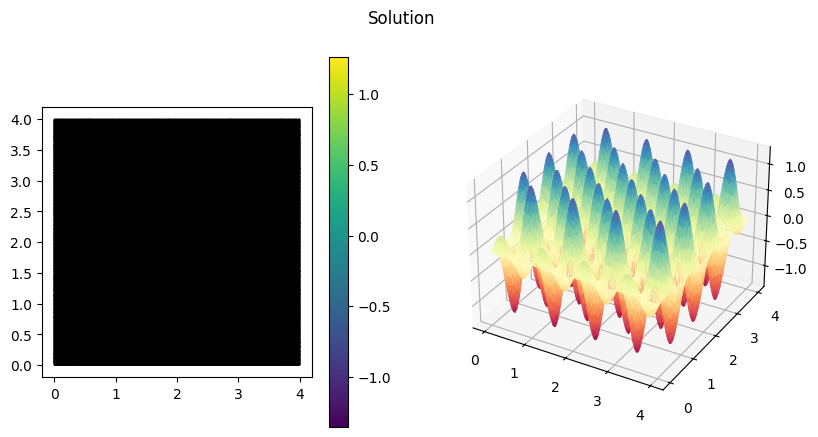

In [9]:
gedim.PlotSolution(mesh, dofs, strongs, u_k1, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k1, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [10]:
inner_product = stiffness
abs_err = []
rel_err = []
error_vector = u_k - u_k1
error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
abs_err.append(absolute_error)

full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
rel_err.append(relative_error)
print(abs_err)

[0.41937882317656583]


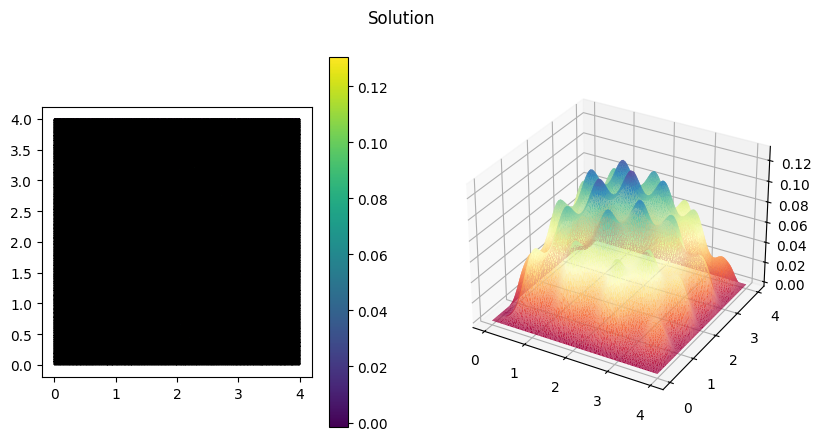

In [11]:
# plot della differenza tra le due soluzioni
gedim.PlotSolution(mesh, dofs, strongs, u_k-u_k1, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k-u_k1, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k-u_k1, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

# POD

## Offline phase 

In [8]:
### define the training set

snapshot_num = 300 
mu0_range = [0.1, 1.]
mu1_range = [0.1, 1.]
P = np.array([mu0_range, mu1_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))
print(P.shape[0])

2


In [9]:
#### snapshot matrix creation
snapshot_matrix = []

tol = 1. -1e-7
N_max = 10

for mu in training_set:
    num_iteration = 1
    u_k_snap = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong_snap = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness_snap, stiffnessStrong_snap] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g_snap = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    while num_iteration < max_iterations: 
        [reaction_snap, reactionStrong_snap] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_snap, u_strong_snap, problemData, lib)
    
        forcingTerm_v_snap = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_snap, u_strong_snap, problemData, lib)
        forcingTerm_der_v_snap = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_snap, u_strong_snap, problemData, lib)
        
        du_snap = gedim.LUSolver(stiffness_snap + reaction_snap, \
                forcingTerm_g_snap - forcingTerm_v_snap - forcingTerm_der_v_snap, \
                lib)
        u_k_snap = u_k_snap + du_snap
        
        #print("dofs", "h", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
        
        num_iteration = num_iteration + 1
    snapshot = u_k_snap
    snapshot_matrix.append(np.copy(snapshot))
    
snapshot_matrix = np.array(snapshot_matrix) 
#print(snapshot_matrix.shape)# 100 valori diversi dei parametri (M=100), su ogni riga ho la soluzione per un determinato parametro valutata nei 713 nodi interni
#print(snapshot_matrix)

In [10]:
### covariance matrix
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
inner_product = stiffness

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 

###### shape?? ############

#### ALTERNATIVE:  VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check


for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)


The reduced dimension is 3


In [11]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) 
  
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (713, 2)


# Online phase

In [12]:
mu = [0.8, 0.4]

u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
u_k_red = np.zeros(N, order='F')

num_iteration = 1
# tutto ciò che non dipende da u_k lo mettiamo fuori dal while
[stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red

while num_iteration < max_iterations: 
    [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
    #reaction = mu[0]*reaction_red
    forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
    forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)

    reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions

    reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
    reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red

    du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
            reduced_g - reduced_v - reduced_der_v, \
            lib)
    u_k_red = u_k_red + du_red

    u_k_proj = basis_functions @ u_k_red
    du_proj = basis_functions @ du_red

    '''du_normL2 = gedim.ComputeErrorL2(Zeros, du_proj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
    u_normL2 = gedim.ComputeErrorL2(Zeros, u_k_proj, u_strong, lib) # we aim it is zero, so we pass to it the zero function
    u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k_proj, u_strong, lib)
    solution_norm_proj = u_normL2;
    residual_norm_proj = du_normL2;

    print("dofs", "h", "residual", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residual_norm_proj / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))'''
        
    num_iteration = num_iteration + 1



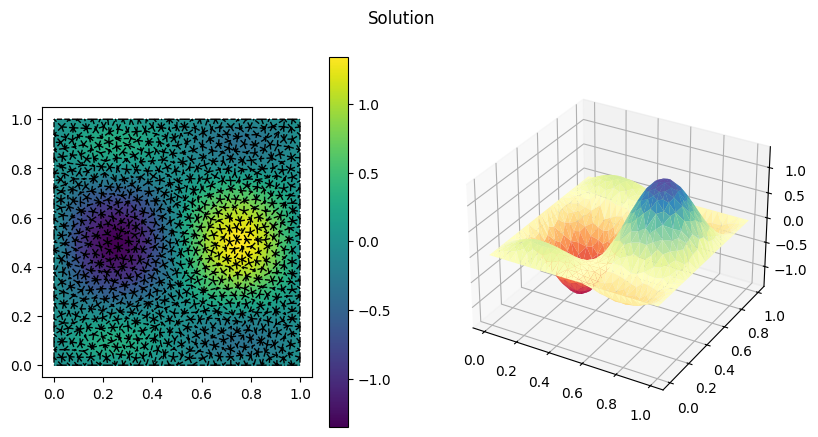

In [13]:
gedim.PlotSolution(mesh, dofs, strongs, u_k_proj, u_strong_red)

In [14]:
### compute error

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    num_iteration = 1
    u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
    
        num_iteration = num_iteration + 1
    
    u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
    u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
    u_k_red = np.zeros(N, order='F')

    num_iteration = 1
    # tutto ciò che non dipende da u_k lo mettiamo fuori dal while
    [stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
    reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
    while num_iteration < max_iterations: 
        [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
        #reaction = mu[0]*reaction_red
        forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)
    
        reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions
    
        reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
        reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red
        du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
                reduced_g - reduced_v - reduced_der_v, \
                lib)
        u_k_red = u_k_red + du_red
    
        u_k_proj = basis_functions @ u_k_red
        du_proj = basis_functions @ du_red
        
        num_iteration = num_iteration + 1
      
    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

Computing error and speedup analysis


In [15]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )

avarege relative error =  0.0008316602288668804
avarege absolute error =  0.003805895969070016


## PINN

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Let us define the Neural Network.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        self.hidden_layer5 = nn.Linear(7,7)
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1):
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1)
        layer1_out = torch.sigmoid(self.input_layer(input)) #
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        output = self.output_layer(layer6_out)
        return output

Model

In [ ]:
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
## PDE as loss function
def R(x_0,x_1,mu_0,mu_1,net):
    u = net(x_0,x_1,mu_0,mu_1) # the dependent variable u is given by the network based on independent variables x_0,x_1,mu_0,mu_1
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0]
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0]

    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0]
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0]

    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))

    pde = -u_xx + mu_0/mu_1*(torch.exp(mu_1*u)-1) - g
    return pde

In [ ]:
## Data from Boundary Conditions
# u(x,0)=0
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,1] and time=0, the value of u is given by 0
# BC tells us that for any y in range[0,1] and time=0, the value of u is given by 0
# Take say 500 random numbers of x
x0_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
x1_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)